In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt

import collections
import random
import numpy as np
import os
import time
import json
from PIL import Image

In [2]:
annotation_folder = '/annotations/'

if not os.path.exists(os.path.abspath('.') + annotation_folder):
    annotation_zip = tf.keras.utils.get_file('captions.zip', cache_subdir=os.path.abspath('.'), origin='http://images.cocodataset.org/annotations/annotations_trainval2014.zip', extract=True)
    annotation_file = os.path.dirname(annotation_zip) + '/annotations/captions_train2014.json'
    os.remove(annotation_zip)

image_folder = '/train2014/'
if not os.path.exists(os.path.abspath('.') + image_folder):
    image_zip = tf.keras.utils.get_file('train2014.zip', cache_subdir=os.path.abspath('.'), origin='http://images.cocodataset.org/zips/train2014.zip', extract=True)
    PATH = os.path.dirname(image_zip) + image_folder
    os.remove(image_zip)
else:
    PATH = os.path.abspath('.') + image_folder

13510574080/13510573713 [==============================] - 327s 0us/step


In [3]:
with open(annotation_file, 'r') as f:
    annotations = json.load(f)

In [4]:
image_path_to_caption = collections.defaultdict(list)

for val in annotations['annotations']:
    caption = f"<start> {val['caption']} <end>"
    image_path = PATH + 'COCO_train2014_' + '%012d.jpg' % (val['image_id'])
    image_path_to_caption[image_path].append(caption)

In [5]:
image_paths = list(image_path_to_caption.keys())
random.shuffle(image_paths)

train_image_paths = image_paths[:6000]
print(len(train_image_paths))
print(train_image_paths[:10])

6000
['/content/train2014/COCO_train2014_000000522933.jpg', '/content/train2014/COCO_train2014_000000233381.jpg', '/content/train2014/COCO_train2014_000000089939.jpg', '/content/train2014/COCO_train2014_000000258272.jpg', '/content/train2014/COCO_train2014_000000320759.jpg', '/content/train2014/COCO_train2014_000000075581.jpg', '/content/train2014/COCO_train2014_000000450860.jpg', '/content/train2014/COCO_train2014_000000578128.jpg', '/content/train2014/COCO_train2014_000000340019.jpg', '/content/train2014/COCO_train2014_000000115299.jpg']


In [6]:
train_captions = []
img_name_vector = []

for image_path in image_paths:
    caption_list = image_path_to_caption[image_path]
    train_captions.extend(caption_list)
    img_name_vector.extend([image_path] * len(caption_list))

<start> a small bird stands at the edge of a bench <end>


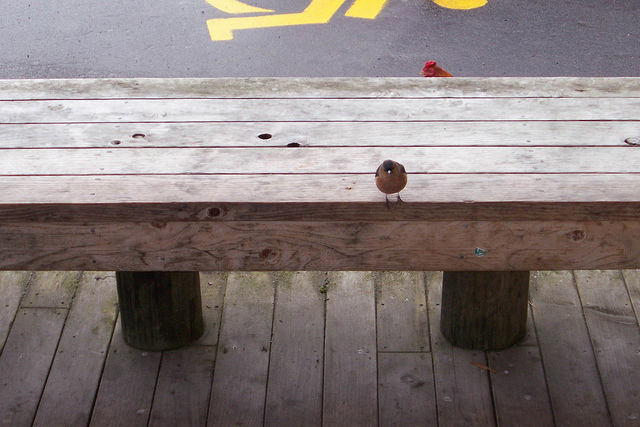

In [7]:
print(train_captions[3])
Image.open(img_name_vector[3])

In [8]:
def load_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (299, 299))
    img = tf.keras.applications.inception_v3.preprocess_input(img)

    return img, image_path

In [9]:
image_model = tf.keras.applications.InceptionV3(include_top=False, weights='imagenet')
new_input = image_model.input
hidden_layer = image_model.layers[-1].output

image_features_extract_model = tf.keras.Model(new_input, hidden_layer)

87916544/87910968 [==============================] - 0s 0us/step


In [10]:
encode_train = sorted(set(img_name_vector))
encode_train[:10]

['/content/train2014/COCO_train2014_000000000009.jpg',
 '/content/train2014/COCO_train2014_000000000025.jpg',
 '/content/train2014/COCO_train2014_000000000030.jpg',
 '/content/train2014/COCO_train2014_000000000034.jpg',
 '/content/train2014/COCO_train2014_000000000036.jpg',
 '/content/train2014/COCO_train2014_000000000049.jpg',
 '/content/train2014/COCO_train2014_000000000061.jpg',
 '/content/train2014/COCO_train2014_000000000064.jpg',
 '/content/train2014/COCO_train2014_000000000071.jpg',
 '/content/train2014/COCO_train2014_000000000072.jpg']

In [11]:
image_dataset = tf.data.Dataset.from_tensor_slices(encode_train)
image_dataset = image_dataset.map(load_image, num_parallel_calls=tf.data.AUTOTUNE).batch(16)

In [12]:
!pip install -q tqdm

In [13]:
from tqdm import tqdm

In [14]:
for img, path in tqdm(image_dataset):
    batch_features = image_features_extract_model(img)
    batch_features = tf.reshape(batch_features, (batch_features.shape[0], -1, batch_features.shape[3]))

    for bf, p in zip(batch_features, path):
        path_of_feature = p.numpy().decode('utf-8')
        np.save(path_of_feature, bf.numpy())

 39%|███▉      | 2029/5174 [07:27<10:08,  5.17it/s]

OSError: ignored

In [ ]:
def calc_max_length(tensor):
    return max(len(t) for t in tensor)

In [ ]:
top_k = 5000

tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=top_k, oov_token='<unk>', filters='!"#$%&()*+.,-/:;=?@[\]^_`{|}~ ')
tokenizer.fit_on_texts(train_captions)

In [ ]:
tokenizer.word_index['<pad>'] = 0
tokenizer.index_word[0] = '<pad>'

In [ ]:
train_seqs = tokenizer.texts_to_sequences(train_captions)

In [ ]:
cap_vector = tf.keras.preprocessing.sequence.pad_sequences(train_seqs, padding='post')

In [ ]:
max_length = calc_max_length(train_seqs)

In [ ]:
img_to_cap_vector = collections.defaultdict(list)
for img, cap in zip(img_name_vector, cap_vector):
    img_to_cap_vector[img].append(cap)

img_keys = list(img_to_cap_vector.keys())
random.shuffle(img_keys)

slice_index = int(len(img_kerys) * 0.8) 